In [1]:
import os
# os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
%matplotlib inline
import collections
import copy
import time
import math
import inspect
import random
import pickle
# import GPUtil
import warnings
# import tiktoken
import torch
import torchvision
# import pandas as pd
# import altair as alt
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

from torch import nn
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn.functional import log_softmax, pad
from torch.utils import data
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import LambdaLR
# from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
# from torchtext.vocab import build_vocab_from_iterator
# import torchtext.datasets as datasets
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

# 设置打印选项，禁用科学计数法
torch.set_printoptions(sci_mode=False)

# 设置打印选项，取消显示省略号
torch.set_printoptions(threshold=float('inf'))

In [2]:
# import torch

# # 查看是否有可用的 GPU
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print(f"CUDA Available. Using GPU: {torch.cuda.get_device_name(device)}")
#     print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)} bytes")
#     print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)} bytes")
# else:
#     print("CUDA not available. Using CPU.")

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
#Ensure PyTorch can utilize CUDA
use_cuda = torch.cuda.is_available()
use_cuda

True

In [5]:
# Define GPU device - We will run our model on GPU
mps_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mps_device

device(type='cuda', index=0)

In [6]:
# 查看显卡信息
!nvidia-smi

Wed Dec 18 14:50:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 553.35                 Driver Version: 553.35         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 5880 Ada Gene...  WDDM  |   00000000:52:00.0  On |                    0 |
| 30%   34C    P8             19W /  285W |    3725MiB /  46068MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# 获取系统中可用的 CUDA 设备（即 GPU）的数量
torch.cuda.device_count()

def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [8]:
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [9]:
try_gpu()

device(type='cuda', index=0)

# 🍔🍕🍔🍔🍕🍔🍕🍕NETWORK CONSTRUCT🥗🥙🥪🌮🌑🌒🌓🌔🌕🌖☀

# 🍕🍔🍕🍕Consititute/Compose/Comprise Data loader 🌓🌔🌕🌖

In [10]:
def load_data():
    train_inputs = []
    train_targets = []
    
    for i in range(1,5158):
        train_input_file = os.path.join(r"C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\train" , f"input-{i}.pt")
        train_target_file = os.path.join(r"C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\train" , f'output-{i}.pt')
        
        train_input_tensor = torch.load(train_input_file)  
        train_target_tensor = torch.load(train_target_file)
        
        train_inputs.append(train_input_tensor)
        train_targets.append(train_target_tensor)
        
    train_input_all = torch.stack(train_inputs).to(mps_device)
    train_target_all = torch.stack(train_targets).to(mps_device)
    
    train_dataset_ = TensorDataset(train_input_all, train_target_all)
    return train_dataset_,train_input_all,train_target_all

In [11]:
train_dataset_, train_input_all, train_target_all = load_data()

In [12]:
print(train_input_all.shape)
print(train_target_all.shape)
print(len(train_dataset_))

torch.Size([5157, 3, 1, 1])
torch.Size([5157, 20, 20])
5157


In [13]:
# DataLoader进行数据封装
train_loader_iter = DataLoader(dataset=train_dataset_, batch_size=256, shuffle=True,drop_last=True)

In [14]:
# 设置打印选项，禁用科学计数法
torch.set_printoptions(sci_mode=False)
for batch_idx, (inputs, targets) in enumerate(train_loader_iter):
    print(f"Batch {batch_idx}:")
    print("Inputs:", inputs)
    print("Targets:", targets)
    break  # 打印第一个批次的数据，移除这行可以打印所有批次

Batch 0:
Inputs: tensor([[[[    -0.5296]],

         [[     1.4228]],

         [[    -0.1434]]],


        [[[    -0.5296]],

         [[    -1.4577]],

         [[    -0.5875]]],


        [[[     0.5901]],

         [[    -0.0663]],

         [[    -0.5506]]],


        [[[     0.5901]],

         [[     0.2168]],

         [[    -0.3711]]],


        [[[     0.5901]],

         [[     0.8542]],

         [[     1.4409]]],


        [[[    -0.5296]],

         [[     0.6596]],

         [[     1.0295]]],


        [[[     0.5901]],

         [[     0.8571]],

         [[     1.4080]]],


        [[[    -0.5296]],

         [[     1.1619]],

         [[     0.1213]]],


        [[[     0.5901]],

         [[     0.8200]],

         [[     1.8808]]],


        [[[    -0.5296]],

         [[    -0.7631]],

         [[    -0.5752]]],


        [[[    -0.5296]],

         [[     1.3078]],

         [[    -0.0699]]],


        [[[    -0.5296]],

         [[     0.1388]],

         [[    -

In [15]:
# 获取训练集的批次数量
num_batches = len(train_loader_iter)
print(f"Total number of batches: {num_batches}")

Total number of batches: 20


In [16]:
def test_load_data():
    test_inputs = []
    test_targets = []
    
    for i in range(1,647):
        test_input_file = os.path.join(r"C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\test" , f"input-{i}.pt")
        test_target_file = os.path.join(r"C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\test" , f'output-{i}.pt')
        
        test_input_tensor = torch.load(test_input_file)  
        test_target_tensor = torch.load(test_target_file)
        
        test_inputs.append(test_input_tensor)
        test_targets.append(test_target_tensor)
        
    test_input_all = torch.stack(test_inputs).to(mps_device)
    test_target_all = torch.stack(test_targets).to(mps_device)
    
    test_dataset_ = TensorDataset(test_input_all, test_target_all)
    return test_dataset_,test_input_all,test_target_all

In [17]:
def valid_load_data():
    valid_inputs = []
    valid_targets = []
    
    for i in range(1,645):
        valid_input_file = os.path.join(r"C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\val" , f"input-{i}.pt")
        valid_target_file = os.path.join(r"C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\val" , f'output-{i}.pt')
        
        valid_input_tensor = torch.load(valid_input_file)  
        valid_target_tensor = torch.load(valid_target_file)
        
        valid_inputs.append(valid_input_tensor)
        valid_targets.append(valid_target_tensor)
        
    valid_input_all = torch.stack(valid_inputs).to(mps_device)
    valid_target_all = torch.stack(valid_targets).to(mps_device)
    
    valid_dataset_ = TensorDataset(valid_input_all, valid_target_all)
    return valid_dataset_,valid_input_all,valid_target_all

In [18]:
test_dataset_, test_input_all, test_target_all = test_load_data()

In [19]:
valid_dataset_, valid_input_all, valid_target_all = valid_load_data()

In [20]:
test_loader_iter = DataLoader(dataset=test_dataset_, batch_size=256, shuffle=True,drop_last=True)

In [21]:
valid_loader_iter = DataLoader(dataset=valid_dataset_, batch_size=256, shuffle=True,drop_last=True)

In [22]:
len(test_loader_iter)

2

In [23]:
len(valid_loader_iter)

2

# 🍕🍔🍕🍕Construct Neural Network 🌓🌔🌕🌖

In [24]:
class BicubicLayer(nn.Module):
    def __init__(self, size=None, scale_factor=None, in_channels=None, out_channels=None,
                 kernel_size=None, padding=None, stride=None):
        super(BicubicLayer, self).__init__()
        
        self.size = size
        self.scale_factor = scale_factor
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, padding=padding, stride=stride)
        
        self.elu = nn.ELU(inplace=True)
        
    def forward(self, X):
        Y = F.interpolate(X, size=self.size, scale_factor=self.scale_factor,mode='bicubic', align_corners=False)
        Y = self.conv(Y)
        Y = self.elu(Y)
        return Y

In [25]:
net_1 = BicubicLayer(size=(16, 16), in_channels=3, out_channels=8, kernel_size=2, padding=(0, 0), stride=(1,1))
net_2 = BicubicLayer(size=(32, 32), in_channels=8, out_channels=16, kernel_size=2, padding=(0, 0), stride=1)
net_3 = BicubicLayer(size=(72, 72), in_channels=16, out_channels=32, kernel_size=3, padding=(1, 1), stride=1) 

In [26]:
# 建立整体网络结构
net_block_1 = nn.Sequential(
    net_1,
    net_2,
    net_3,).to(try_gpu())

In [27]:
from torchsummary import summary
summary(net_block_1, input_size=(3,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             104
               ELU-2            [-1, 8, 15, 15]               0
      BicubicLayer-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 16, 31, 31]             528
               ELU-5           [-1, 16, 31, 31]               0
      BicubicLayer-6           [-1, 16, 31, 31]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
Total params: 5,272
Trainable params: 5,272
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 4.19
Params size (MB): 0.02
Estimated Total Size (MB): 4.21
-----------------------------------------------

In [28]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides) #高宽不变
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y =  F.relu(self.bn1(self.conv1(X)))  
        Y = self.bn2(self.conv2(Y))         
        if self.conv3:
            X = self.conv3(X)                
        Y += X
        return F.relu(Y)

In [29]:
net_4 = Residual(32,48,use_1x1conv=True)
net_5 = Residual(48,56,use_1x1conv=True)
net_6 = Residual(56,64,use_1x1conv=True)

In [30]:
# 建立整体网络结构
net_block_2 = nn.Sequential(
    net_1,
    net_2,
    net_3,
    net_4,
    net_5,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_6,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    ).to(try_gpu())

In [31]:
from torchsummary import summary
summary(net_block_2, input_size=(3,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             104
               ELU-2            [-1, 8, 15, 15]               0
      BicubicLayer-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 16, 31, 31]             528
               ELU-5           [-1, 16, 31, 31]               0
      BicubicLayer-6           [-1, 16, 31, 31]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
           Conv2d-10           [-1, 48, 72, 72]          13,872
      BatchNorm2d-11           [-1, 48, 72, 72]              96
           Conv2d-12           [-1, 48, 72, 72]          20,784
      BatchNorm2d-13           [-1, 48, 72, 72]              96
           Conv2d-14           [-1, 48,

In [32]:
class Flatten_Module(nn.Module):
    def __init__(self):
        super(Flatten_Module, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64 * 18 * 18, 400)

    def forward(self, x):

        flattened = self.flatten(x)  # Shape will be [batch_size, 64 * 9 * 9]
        linear_output = self.linear(flattened)  # Shape will be [batch_size, 1200]
        
        # Reshape to desired shape [batch_size, 20, 60]
        reshaped = linear_output.view( -1,20, 20)
        
        return reshaped

In [33]:
net_7 = Flatten_Module()

In [34]:
# 建立整体网络结构
net = nn.Sequential(
    net_1,
    net_2,
    net_3,
    net_4,
    net_5,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_6,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_7
    ).to(try_gpu())

In [35]:
from torchsummary import summary
summary(net, input_size=(3,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             104
               ELU-2            [-1, 8, 15, 15]               0
      BicubicLayer-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 16, 31, 31]             528
               ELU-5           [-1, 16, 31, 31]               0
      BicubicLayer-6           [-1, 16, 31, 31]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
           Conv2d-10           [-1, 48, 72, 72]          13,872
      BatchNorm2d-11           [-1, 48, 72, 72]              96
           Conv2d-12           [-1, 48, 72, 72]          20,784
      BatchNorm2d-13           [-1, 48, 72, 72]              96
           Conv2d-14           [-1, 48,

# 🍕🍔🍕🍕Trainning 🌓🌔🌕🌖

In [36]:
batch_size = 256
num_epochs = 50
initial_lr = 0.0005
decay_rate = 0.9

In [37]:
loss = nn.MSELoss()
# 定义优化器
optimizer = torch.optim.AdamW(net.parameters(), lr=initial_lr)

# 定义学习率调度器：指数衰减
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

Epoch [1/50], traning_Loss: 0.0192, Learning Rate: 0.00000090
Epoch [1/50], validation_Loss: 0.0120, Learning Rate: 0.00000090
Epoch [2/50], traning_Loss: 0.0200, Learning Rate: 0.00000090
Epoch [2/50], validation_Loss: 0.0128, Learning Rate: 0.00000090
Epoch [3/50], traning_Loss: 0.0197, Learning Rate: 0.00000090
Epoch [3/50], validation_Loss: 0.0123, Learning Rate: 0.00000090
Epoch [4/50], traning_Loss: 0.0206, Learning Rate: 0.00000090
Epoch [4/50], validation_Loss: 0.0133, Learning Rate: 0.00000090
Epoch [5/50], traning_Loss: 0.0202, Learning Rate: 0.00000081
Epoch 5 completed. Learning Rate: 0.00000081
Epoch [5/50], validation_Loss: 0.0125, Learning Rate: 0.00000081
Epoch [6/50], traning_Loss: 0.0194, Learning Rate: 0.00000081
Epoch [6/50], validation_Loss: 0.0128, Learning Rate: 0.00000081
Epoch [7/50], traning_Loss: 0.0200, Learning Rate: 0.00000081
Epoch [7/50], validation_Loss: 0.0124, Learning Rate: 0.00000081
Epoch [8/50], traning_Loss: 0.0194, Learning Rate: 0.00000081
Epoc

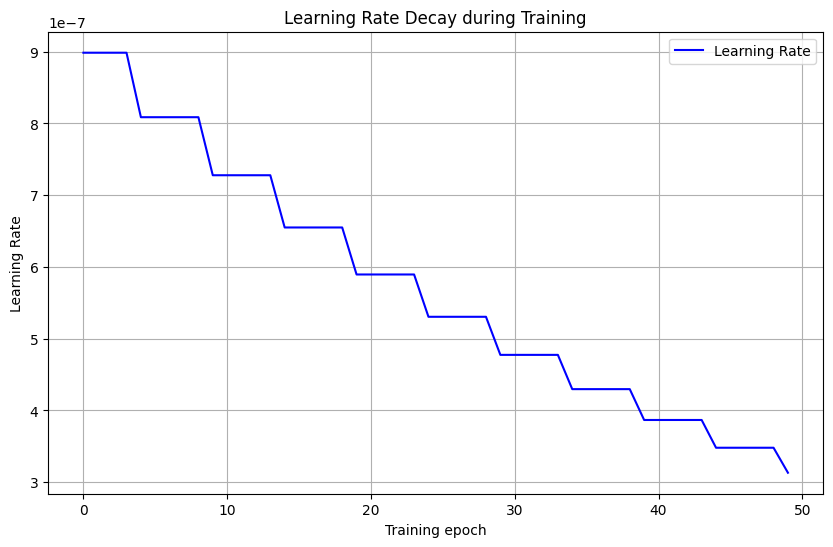

Training finished.


In [56]:
# 用于记录每个step的学习率
lr_history = []
best_val_loss = float('inf')  # 初始设为无穷大，以便后续能够找到更低的损失值
best_model_state = None

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses

for epoch in range(num_epochs):
    # Training phase
    net.train()
    train_loss = 0.0
    
    for X, y in train_loader_iter:
        optimizer.zero_grad()
        outputs = net(X)
        loss_value = loss(outputs, y)
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item()
        
    train_losses.append(train_loss)  # Store the training loss  

    # 每经过5个epoch，学习率衰减一次
    if (epoch + 1) % 5 == 0:  # 每5个epoch更新一次学习率
        scheduler.step()

    # 打印每个epoch的学习率
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)  # 记录当前batch的学习率
    print(f"Epoch [{epoch+1}/{num_epochs}], traning_Loss: {train_loss/len(train_loader_iter):.4f}, Learning Rate: {current_lr:.8f}")

    # 每5个epoch打印一次
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1} completed. Learning Rate: {current_lr:.8f}")

   
    # Validation phase
    net.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_val, y_val in valid_loader_iter:
            outputs = net(X_val)
            val_loss += loss(outputs, y_val).item()
            
    val_losses.append(val_loss)  # Store the validation loss
    
    # Check if this is the best model by validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = net.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}], validation_Loss: {val_loss/len(valid_loader_iter):.4f}, Learning Rate: {current_lr:.8f}")
    
# Save the best model state
torch.save(best_model_state, 'best_model_1_1.pth')

# 训练结束后，绘制学习率曲线
plt.figure(figsize=(10, 6))
plt.plot(lr_history, label='Learning Rate', color='b')
plt.xlabel('Training epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay during Training')
plt.legend()
plt.grid(True)
plt.show()

print("Training finished.")

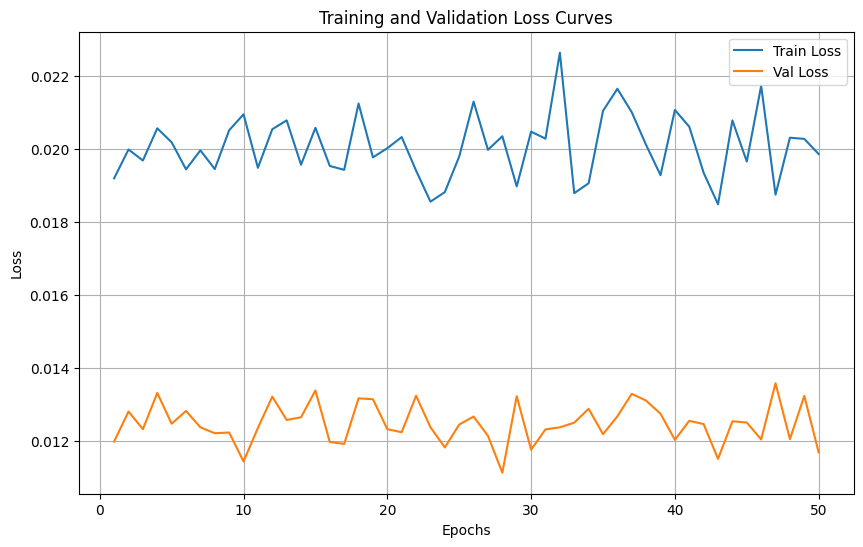

In [57]:
# Plotting the training and validation loss curves 
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), [loss / len(train_loader_iter) for loss in train_losses], label='Train Loss')
plt.plot(range(1, num_epochs + 1), [loss / len(valid_loader_iter) for loss in val_losses], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Step 2: Load the best model state
best_model = torch.load('best_model_1_1.pth')

# Step 3: Load state dict into the model
net.load_state_dict(best_model)

# Step 4: Set the model to evaluation mode
net.eval()

# Step 5: Evaluate on the test set
test_loss = 0.0

with torch.no_grad():
    for X_test, y_test in test_loader_iter:
        outputs = net(X_test)
        test_loss += loss(outputs, y_test).item() * X_test.size(0)

# Calculate average test loss
test_loss = test_loss / len(test_loader_iter.dataset)

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0103


In [ ]:
C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\test

In [59]:
target_mean=837.4973
target_std=617.3029

In [77]:
# Step 1: 加载训练好的模型
best_model = torch.load('best_model_1_1.pth')  # 假设 'best_model.pth' 是你保存的最佳模型
net.load_state_dict(best_model)  # 将模型参数加载到模型中
net.eval()  # 设置模型为评估模式

# Step 2: 加载 input2.pt 和 output2.pt
input_tensor = torch.load(r'C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\test\input-1.pt')  # 加载 input2.pt
output_tensor = torch.load(r'C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\test\output-1.pt')  # 加载 output2.pt

# 检查输入张量的形状
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")

# 将输入张量转移到正确的设备上 (GPU 或 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)
output_tensor = output_tensor.to(device)
net.to(device)  # 确保模型也在相同设备上

# Step 3: 对 input2.pt 进行预测
with torch.no_grad():  # 禁用梯度计算，因为我们只做推理
    predicted_output = net(input_tensor.unsqueeze(0))  # 假设输入是 [batch_size, channels, height, width]
    
# 打印预测结果
print(f"Predicted output: {predicted_output}")

Input tensor shape: torch.Size([3, 1, 1])
Output tensor shape: torch.Size([20, 20])
Predicted output: tensor([[[0.9186, 1.2275, 2.3973, 2.4532, 0.4805, 1.4157, 0.6123, 2.5199,
          2.4238, 2.4130, 1.6018, 1.6734, 2.5083, 2.4579, 1.5805, 1.3628,
          1.2750, 2.5553, 2.5755, 1.7139],
         [1.4358, 2.2564, 1.4491, 1.5811, 1.3720, 0.8220, 2.3755, 1.4855,
          1.1090, 1.1322, 1.5699, 1.0861, 1.8837, 2.2183, 2.3086, 1.9090,
          1.8536, 2.1189, 1.4954, 1.5182],
         [1.6581, 2.1783, 2.8356, 2.5441, 1.6222, 0.7769, 1.6114, 2.5474,
          2.5985, 2.2687, 1.6363, 1.8026, 2.6525, 2.4473, 2.4581, 2.5549,
          2.4341, 2.5748, 2.6879, 2.3119],
         [1.7700, 1.9785, 1.4541, 2.2533, 2.3311, 2.2698, 2.2051, 2.1152,
          1.4326, 2.2188, 2.2006, 1.9383, 2.3820, 2.4942, 2.6607, 1.9725,
          2.5466, 2.2485, 2.2350, 2.2550],
         [1.1688, 2.7120, 2.7254, 2.5285, 2.6163, 2.2551, 2.5278, 2.5245,
          2.5906, 2.6365, 0.7631, 2.5403, 2.7402, 2.7432, 2.

In [78]:
Predicted_output_reverse=predicted_output * target_std + target_mean
Predicted_output_reverse

tensor([[[1404.5571, 1595.2080, 2317.3857, 2351.8496, 1134.1152, 1711.4351,
          1215.4519, 2393.0176, 2333.7324, 2327.0386, 1826.3125, 1870.4832,
          2385.8562, 2354.7744, 1813.1357, 1678.7434, 1624.5494, 2414.8882,
          2427.3501, 1895.4670],
         [1723.8505, 2230.3652, 1732.0526, 1813.5410, 1684.4370, 1344.9377,
          2303.8955, 1754.5168, 1522.0817, 1536.4088, 1806.6288, 1507.9314,
          2000.2998, 2206.8374, 2262.6016, 2015.9117, 1981.7551, 2145.5239,
          1760.6038, 1774.6720],
         [1861.0637, 2182.1909, 2587.9004, 2407.9795, 1838.9133, 1317.0502,
          1832.2339, 2410.0156, 2441.5337, 2237.9424, 1847.6152, 1950.2451,
          2474.8806, 2348.2109, 2354.8809, 2414.6699, 2340.0769, 2426.9395,
          2496.7236, 2264.6379],
         [1930.0975, 2058.8027, 1735.0903, 2228.4409, 2276.5215, 2238.6602,
          2198.7222, 2143.2026, 1721.8174, 2207.1836, 2195.9429, 2034.0255,
          2307.8955, 2377.1826, 2479.9805, 2055.1013, 2409.4922, 

In [79]:
output_tensor_reverse=output_tensor * target_std + target_mean
output_tensor_reverse

tensor([[1412.4894, 1607.5339, 2332.2271, 2347.4912, 1151.9065, 1705.5854,
         1247.7651, 2394.2803, 2337.2021, 2324.4507, 1836.3921, 1876.0480,
         2382.9873, 2331.0464, 1822.0901, 1683.9795, 1652.5594, 2424.0161,
         2430.9043, 1910.6649],
        [1767.1035, 2264.6597, 1749.3098, 1802.9033, 1661.1184, 1351.1063,
         2323.1870, 1752.7821, 1523.3411, 1557.9613, 1823.3057, 1513.7275,
         1998.5438, 2214.1572, 2250.5063, 1986.4149, 1999.1930, 2182.7446,
         1763.7224, 1818.6064],
        [1871.1332, 2176.3853, 2597.5669, 2335.6328, 1870.8080, 1322.1322,
         1766.9930, 2402.4844, 2527.0247, 2264.7617, 1846.5793, 1954.5392,
         2480.0654, 2330.2026, 2378.4849, 2414.1265, 2360.7202, 2332.7505,
         2502.5039, 2284.1772],
        [1930.6036, 2073.3501, 1759.3566, 2161.9419, 2331.4121, 2271.6709,
         2202.2622, 2170.6704, 1755.8942, 2207.3965, 2200.7007, 2047.1200,
         2306.7798, 2382.4563, 2492.8247, 2014.1627, 2444.4204, 2268.0459,
    

In [80]:
output_tensor_reverse-Predicted_output_reverse

tensor([[[     7.9323,     12.3259,     14.8413,     -4.3584,     17.7913,
              -5.8496,     32.3132,      1.2627,      3.4697,     -2.5879,
              10.0796,      5.5648,     -2.8689,    -23.7280,      8.9543,
               5.2361,     28.0100,      9.1279,      3.5542,     15.1979],
         [    43.2531,     34.2944,     17.2572,    -10.6377,    -23.3186,
               6.1686,     19.2915,     -1.7347,      1.2594,     21.5525,
              16.6769,      5.7961,     -1.7560,      7.3198,    -12.0952,
             -29.4968,     17.4379,     37.2207,      3.1187,     43.9344],
         [    10.0695,     -5.8057,      9.6665,    -72.3467,     31.8947,
               5.0820,    -65.2408,     -7.5312,     85.4910,     26.8193,
              -1.0359,      4.2941,      5.1848,    -18.0083,     23.6040,
              -0.5435,     20.6433,    -94.1890,      5.7803,     19.5393],
         [     0.5061,     14.5474,     24.2662,    -66.4990,     54.8906,
              33.0107,

In [81]:
(output_tensor_reverse-Predicted_output_reverse)/output_tensor_reverse

tensor([[[     0.0056,      0.0077,      0.0064,     -0.0019,      0.0154,
              -0.0034,      0.0259,      0.0005,      0.0015,     -0.0011,
               0.0055,      0.0030,     -0.0012,     -0.0102,      0.0049,
               0.0031,      0.0169,      0.0038,      0.0015,      0.0080],
         [     0.0245,      0.0151,      0.0099,     -0.0059,     -0.0140,
               0.0046,      0.0083,     -0.0010,      0.0008,      0.0138,
               0.0091,      0.0038,     -0.0009,      0.0033,     -0.0054,
              -0.0148,      0.0087,      0.0171,      0.0018,      0.0242],
         [     0.0054,     -0.0027,      0.0037,     -0.0310,      0.0170,
               0.0038,     -0.0369,     -0.0031,      0.0338,      0.0118,
              -0.0006,      0.0022,      0.0021,     -0.0077,      0.0099,
              -0.0002,      0.0087,     -0.0404,      0.0023,      0.0086],
         [     0.0003,      0.0070,      0.0138,     -0.0308,      0.0235,
               0.0145,

In [82]:
A=(output_tensor_reverse-Predicted_output_reverse)/output_tensor_reverse

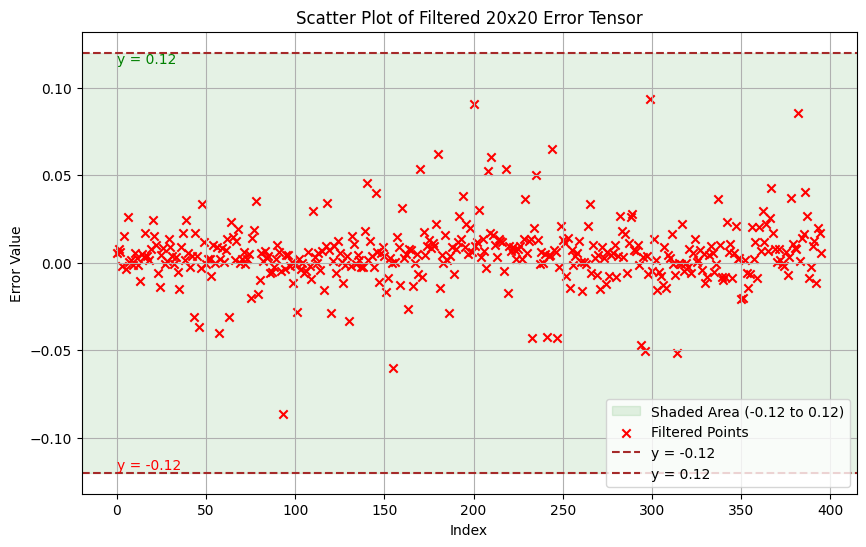

In [85]:
# Step 1: Flatten the tensor to 1x400
flattened_A = A.flatten()

# Step 2: Remove values that are not within [-0.12, 0.12]
flattened_A = flattened_A[(flattened_A >= -0.12) & (flattened_A <= 0.12)]

# Step 3: Visualize the filtered values as a scatter plot
filtered_A_numpy = flattened_A.cpu().numpy()

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Add shading for the region between -0.12 and 0.12
plt.axhspan(-0.12, 0.12, color='green', alpha=0.1, label='Shaded Area (-0.12 to 0.12)')

# Scatter plot for filtered values
plt.scatter(range(len(filtered_A_numpy)), filtered_A_numpy, color='red', marker='x', alpha=1, label='Filtered Points')

# Add horizontal lines at y = -0.12 and y = 0.12
plt.axhline(y=-0.12, color='brown', linestyle='--', label='y = -0.12')
plt.axhline(y=0.12, color='brown', linestyle='--', label='y = 0.12')

# Add text labels for the horizontal lines
plt.text(0, -0.12, 'y = -0.12', color='r', verticalalignment='bottom', horizontalalignment='left')
plt.text(0, 0.12, 'y = 0.12', color='g', verticalalignment='top', horizontalalignment='left')

# Label the axes and add a title
plt.xlabel('Index')
plt.ylabel('Error Value')
plt.title('Scatter Plot of Filtered 20x20 Error Tensor')

# Show grid, legend, and plot
plt.grid(True)
plt.legend()
plt.show()

In [263]:
# Step 1: 加载训练好的模型
best_model = torch.load('best_model.pth')  # 假设 'best_model.pth' 是你保存的最佳模型
net.load_state_dict(best_model)  # 将模型参数加载到模型中
net.eval()  # 设置模型为评估模式

# Step 2: 加载 input2.pt 和 output2.pt
input_tensor = torch.load(r'C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\test\input-1.pt')  # 加载 input2.pt
output_tensor = torch.load(r'C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\test\output-1.pt')  # 加载 output2.pt

# 检查输入张量的形状
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")

# 将输入张量转移到正确的设备上 (GPU 或 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)
output_tensor = output_tensor.to(device)
net.to(device)  # 确保模型也在相同设备上

# Step 3: 对 input2.pt 进行预测
with torch.no_grad():  # 禁用梯度计算，因为我们只做推理
    predicted_output = net(input_tensor.unsqueeze(0))  # 假设输入是 [batch_size, channels, height, width]
    
# 打印预测结果
print(f"Predicted output: {predicted_output}")

# # Step 4: 对比预测结果与实际输出
# # 假设你是做回归任务或者是对比连续值，可以用 L2 Loss（均方误差）来比较
# loss_fn = nn.MSELoss()  # 均方误差损失函数
# loss_value = loss_fn(predicted_output, output_tensor.unsqueeze(0))  # 扩展维度匹配 batch size
# print(f"Prediction Loss (MSE): {loss_value.item()}")

Input tensor shape: torch.Size([3, 1, 1])
Output tensor shape: torch.Size([20, 20])
Predicted output: tensor([[[0.9088, 1.2262, 2.3607, 2.4372, 0.4752, 1.2918, 0.6362, 2.4895,
          2.3841, 2.3730, 1.6477, 1.7292, 2.4810, 2.3712, 1.6445, 1.4493,
          1.3148, 2.5510, 2.5338, 1.7411],
         [1.5806, 2.2803, 1.3754, 1.5082, 1.3202, 0.7797, 2.3534, 1.4039,
          1.0970, 1.1729, 1.5911, 1.1307, 1.9405, 2.2344, 2.3001, 1.8452,
          1.9340, 2.2197, 1.5851, 1.6383],
         [1.7335, 2.1847, 2.7336, 2.4782, 1.6201, 0.7805, 1.5329, 2.4780,
          2.5507, 2.2674, 1.6675, 1.7605, 2.6346, 2.3044, 2.4592, 2.5146,
          2.4626, 2.5476, 2.6456, 2.3611],
         [1.8445, 1.9551, 1.4531, 2.1706, 2.2921, 2.2486, 2.1089, 2.0737,
          1.4604, 2.1764, 2.1610, 1.9311, 2.3421, 2.4618, 2.6442, 1.8920,
          2.5658, 2.3500, 2.1587, 2.2383],
         [1.2333, 2.7023, 2.6749, 2.5816, 2.5835, 2.2405, 2.4425, 2.4373,
          2.5300, 2.5901, 0.7898, 2.5275, 2.6697, 2.6290, 2.

In [264]:
output_tensor

tensor([[ 0.9315,  1.2474,  2.4214,  2.4461,  0.5093,  1.4063,  0.6646,  2.5219,
          2.4294,  2.4088,  1.6182,  1.6824,  2.5036,  2.4195,  1.5950,  1.3713,
          1.3204,  2.5701,  2.5812,  1.7385],
        [ 1.5059,  2.3119,  1.4771,  1.5639,  1.3342,  0.8320,  2.4067,  1.4827,
          1.1110,  1.1671,  1.5970,  1.0955,  1.8808,  2.2301,  2.2890,  1.8612,
          1.8819,  2.1792,  1.5004,  1.5893],
        [ 1.6744,  2.1689,  2.8512,  2.4269,  1.6739,  0.7851,  1.5057,  2.5352,
          2.7370,  2.3121,  1.6347,  1.8096,  2.6609,  2.4181,  2.4963,  2.5541,
          2.4675,  2.4222,  2.6972,  2.3435],
        [ 1.7708,  2.0020,  1.4934,  2.1455,  2.4201,  2.3233,  2.2109,  2.1597,
          1.4878,  2.2192,  2.2083,  1.9595,  2.3802,  2.5028,  2.6815,  1.9061,
          2.6031,  2.3174,  2.3659,  2.1925],
        [ 1.1440,  2.7348,  2.7297,  2.5554,  2.6259,  2.2699,  2.5050,  2.5030,
          2.5817,  2.6459,  0.7846,  2.5647,  2.7201,  2.4169,  2.7165,  2.7277,
      

In [265]:
Predicted_output_reverse=predicted_output * target_std + target_mean
Predicted_output_reverse

tensor([[[1398.5162, 1594.4495, 2294.7788, 2341.9573, 1130.8516, 1634.9506,
          1230.2239, 2374.2925, 2309.2263, 2302.3579, 1854.6558, 1904.9624,
          2369.0291, 2301.2434, 1852.6305, 1732.1777, 1649.1519, 2412.2668,
          2401.6023, 1912.2839],
         [1813.2352, 2245.1189, 1686.5227, 1768.5076, 1652.4731, 1318.7788,
          2290.2646, 1704.1331, 1514.6919, 1561.5435, 1819.6868, 1535.4657,
          2035.3464, 2216.8044, 2257.3586, 1976.5593, 2031.3804, 2207.7371,
          1815.9885, 1848.8518],
         [1907.6023, 2186.0959, 2524.9856, 2367.2700, 1837.5894, 1319.3026,
          1783.7502, 2367.1492, 2412.0256, 2237.1895, 1866.8293, 1924.2527,
          2463.8508, 2260.0066, 2355.5491, 2389.7642, 2357.6440, 2410.1594,
          2470.6387, 2295.0154],
         [1976.0984, 2044.3669, 1734.5306, 2177.4128, 2252.4331, 2225.5391,
          2139.3040, 2117.5918, 1739.0100, 2181.0181, 2171.4629, 2029.5627,
          2283.2759, 2357.1958, 2469.7800, 2005.4573, 2421.3567, 

In [266]:
output_tensor_reverse=output_tensor * target_std + target_mean
output_tensor_reverse

tensor([[1412.4893, 1607.5338, 2332.2268, 2347.4910, 1151.9064, 1705.5853,
         1247.7650, 2394.2800, 2337.2021, 2324.4507, 1836.3920, 1876.0479,
         2382.9871, 2331.0464, 1822.0900, 1683.9792, 1652.5593, 2424.0156,
         2430.9043, 1910.6648],
        [1767.1033, 2264.6594, 1749.3096, 1802.9031, 1661.1183, 1351.1062,
         2323.1868, 1752.7820, 1523.3409, 1557.9612, 1823.3055, 1513.7274,
         1998.5437, 2214.1572, 2250.5061, 1986.4148, 1999.1929, 2182.7444,
         1763.7222, 1818.6062],
        [1871.1331, 2176.3850, 2597.5664, 2335.6328, 1870.8079, 1322.1321,
         1766.9929, 2402.4841, 2527.0244, 2264.7617, 1846.5792, 1954.5391,
         2480.0652, 2330.2024, 2378.4844, 2414.1262, 2360.7202, 2332.7505,
         2502.5037, 2284.1772],
        [1930.6035, 2073.3499, 1759.3564, 2161.9419, 2331.4119, 2271.6709,
         2202.2620, 2170.6702, 1755.8940, 2207.3965, 2200.7007, 2047.1199,
         2306.7798, 2382.4561, 2492.8245, 2014.1626, 2444.4202, 2268.0457,
    

In [267]:
output_tensor_reverse-Predicted_output_reverse

tensor([[[    13.9730,     13.0844,     37.4480,      5.5337,     21.0548,
              70.6348,     17.5411,     19.9875,     27.9758,     22.0928,
             -18.2638,    -28.9146,     13.9580,     29.8030,    -30.5405,
             -48.1985,      3.4075,     11.7488,     29.3020,     -1.6191],
         [   -46.1320,     19.5405,     62.7869,     34.3955,      8.6451,
              32.3274,     32.9221,     48.6489,      8.6490,     -3.5823,
               3.6188,    -21.7383,    -36.8027,     -2.6472,     -6.8525,
               9.8555,    -32.1875,    -24.9927,    -52.2664,    -30.2456],
         [   -36.4692,     -9.7109,     72.5808,    -31.6372,     33.2185,
               2.8295,    -16.7573,     35.3350,    114.9988,     27.5723,
             -20.2501,     30.2864,     16.2144,     70.1958,     22.9353,
              24.3621,      3.0762,    -77.4089,     31.8650,    -10.8381],
         [   -45.4949,     28.9829,     24.8258,    -15.4709,     78.9788,
              46.1318,

In [123]:
# Step 2: Load the best model state
best_model = torch.load('best_model.pth')

# Step 3: Load state dict into the model
net.load_state_dict(best_model)

# Step 4: Set the model to evaluation mode
net.eval()

# Step 5: Evaluate on the test set
test_loss = 0.0

with torch.no_grad():
    for X_test, y_test in test_loader_iter:
        outputs = net(X_test)
        test_loss += loss(outputs, y_test).item() * X_test.size(0)

# Calculate average test loss
test_loss = test_loss / len(test_loader_iter.dataset)

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0248


In [124]:
outputs.shape

torch.Size([256, 20, 20])

In [129]:
outputs

tensor([[[    -0.2611,     -0.1655,      1.2973,      1.3124,     -0.1064,
               0.4147,     -0.0392,      1.5228,      1.4478,      0.3282,
               0.3165,      0.2600,      1.5071,      1.5649,      0.2468,
               0.1242,      0.0123,      1.3123,      1.3348,      0.0831],
         [    -0.2409,      0.0280,     -0.1217,      0.2094,      0.2938,
              -0.0938,      0.3642,      0.5324,      0.1402,      0.0297,
               0.3386,      0.0729,      0.2670,      0.6094,      0.3051,
               0.3481,      0.3069,      0.1992,     -0.0649,     -0.1038],
         [    -0.0454,      0.2564,      0.9861,      1.3130,      0.1393,
              -0.1817,      0.1981,      1.2425,      1.3587,      0.3160,
               0.3639,      0.6842,      1.5911,      1.5173,      1.0513,
               1.1387,      0.7572,      1.2549,      1.2776,      0.3549],
         [     0.2037,      0.6989,     -0.0539,     -0.2256,      0.1338,
               0.1396,

In [128]:
# 设置打印选项，禁用科学计数法
torch.set_printoptions(sci_mode=False)
global_mean = 5.00992488861084
global_std = 3.157698392868042

# 逆 Z-score 归一化公式
outputs_original = outputs * target_std + target_mean

# 查看逆归一化后的 outputs 张量
print(outputs_original.shape)
print(outputs_original)

torch.Size([256, 20, 20])
tensor([[[ 676.3435,  735.3627, 1638.3450, 1647.6492,  771.7860, 1093.5076,
           813.2999, 1777.5127, 1731.2329, 1040.0996, 1032.8694,  998.0167,
          1767.8638, 1803.5308,  989.8725,  914.1452,  845.1093, 1647.5837,
          1661.4990,  888.8061],
         [ 688.7969,  854.7537,  762.3448,  966.7789, 1018.8466,  779.6143,
          1062.3308, 1166.1672,  924.0190,  855.8291, 1046.5402,  882.5114,
          1002.3473, 1213.6570, 1025.8234, 1052.3594, 1026.9402,  960.4373,
           797.4507,  773.4100],
         [ 809.5003,  995.7535, 1446.2131, 1648.0378,  923.4617,  725.3173,
           959.8136, 1604.4951, 1676.2146, 1032.5665, 1062.1466, 1259.8503,
          1819.7079, 1774.1531, 1486.4635, 1540.3921, 1304.8892, 1612.1744,
          1626.1589, 1056.5756],
         [ 963.2695, 1268.9363,  804.2058,  698.2361,  920.1180,  923.6671,
          1188.4613, 1078.8335,  864.3426, 1393.0291, 1446.8660, 1365.2753,
          1046.8721, 1513.4562, 1689.85

In [ ]:
C:\Users\wang.zhuo17\V1\test\input
C:\Users\wang.zhuo17\V1\test\target
C:\Users\wang.zhuo17\V1\test